# Model training: BERT (emotion)

---

## Table of Contents

1. [Imports](#imports)
2. [Data loading and splitting](#data-loading-and-splitting)
3. [Setting training parameters](#setting-training-parameters)
4. [Model training](#model-training)
5. [Model evaluation](#model-evaluation)
6. [Model serialization](#model-serialization)

# Imports

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Data loading and splitting

In [2]:
train_file = '../train_emotion.csv'
val_file = '../val_emotion.csv'
test_file = '../test_emotion.csv'

if not all([os.path.exists(train_file), os.path.exists(val_file), os.path.exists(test_file)]):
    emotion_df = pd.read_parquet('../../data/emotion_without_outliers/emotion_without_outliers.parquet')
    emotion_df = emotion_df.drop(columns=['text_length'])
    
    target_samples_per_class = 16_667  # 100k / 6 classes of emotions
    
    balanced_data = emotion_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), target_samples_per_class), random_state=42)
    )
    
    train_data, temp_data = train_test_split(balanced_data, test_size=0.3, stratify=balanced_data['label'], random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

    train_data.to_csv(train_file, index=False)
    val_data.to_csv(val_file, index=False)
    test_data.to_csv(test_file, index=False)
else:
    train_data = pd.read_csv(train_file)
    val_data = pd.read_csv(val_file)
    test_data = pd.read_csv(test_file)

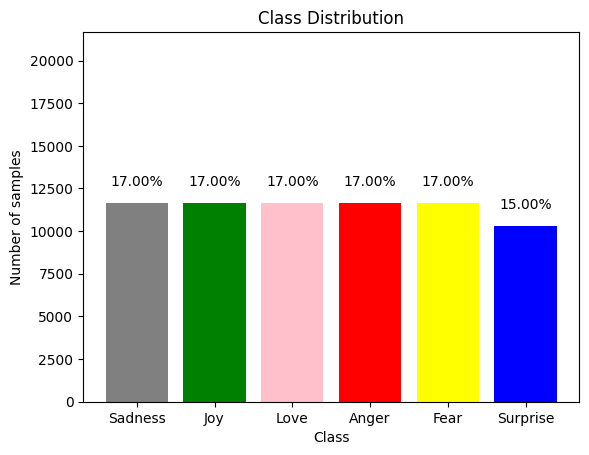

In [3]:
class_counts = train_data['label'].value_counts()
class_labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
class_percentages = (class_counts / class_counts.sum()) * 100

class_counts_dict = {class_labels[key]: class_counts[key] for key in class_labels.keys()}
class_percentages_dict = {class_labels[key]: class_percentages[key] for key in class_labels.keys()}

plt.bar(class_counts_dict.keys(), class_counts_dict.values(), color=['grey', 'green', 'pink', 'red', 'yellow', 'blue'])

for label, count in class_counts_dict.items():
    percentage = f'{class_percentages_dict[label]:.2f}%'
    plt.text(list(class_counts_dict.keys()).index(label), count + 1000, percentage, ha='center')

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.ylim(0, class_counts.max() + 10000)
plt.show()

# Setting training parameters

Due to the uneven distribution of classes in the dataset, the classes will be weighted.

In [4]:
class_weights = compute_class_weight('balanced', classes=pd.unique(train_data['label']), y=train_data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
class LabeledDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text']
        self.labels = data['label']
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [7]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    dataset = LabeledDataset(data, tokenizer, max_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
train_loader = create_data_loader(train_data, tokenizer, max_len=256, batch_size=16)
val_loader = create_data_loader(val_data, tokenizer, max_len=256, batch_size=16)
test_loader = create_data_loader(test_data, tokenizer, max_len=256, batch_size=16)

# Model training

In [9]:
device = 'cuda'

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
loss_fn = CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

C:\Users\Olga\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        _, preds = outputs.logits.max(1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch_idx % 10 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = 100. * correct_predictions / total_samples
            print(f"Epoch: {epoch}. Batch {batch_idx}/{len(data_loader)} - Avg Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct_predictions / total_samples
    return avg_loss, accuracy

In [13]:
def eval_model(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)

    return correct_predictions.double() / total_predictions

In [14]:
for epoch in range(5):
    train_loss, train_accuracy = train_epoch(model, train_loader, loss_fn, optimizer, device, epoch)
    print(f"Train loss: {train_loss:.4f} - Train accuracy: {train_accuracy:.2f}%")
    val_accuracy = eval_model(model, val_loader, device)
    print(f"Validation accuracy: {val_accuracy:.4f}")

Epoch: 0. Batch 0/4290 - Avg Loss: 1.8444 - Accuracy: 6.25%
Epoch: 0. Batch 10/4290 - Avg Loss: 1.8074 - Accuracy: 13.64%
Epoch: 0. Batch 20/4290 - Avg Loss: 1.7865 - Accuracy: 18.75%
Epoch: 0. Batch 30/4290 - Avg Loss: 1.7861 - Accuracy: 20.77%
Epoch: 0. Batch 40/4290 - Avg Loss: 1.7834 - Accuracy: 21.34%
Epoch: 0. Batch 50/4290 - Avg Loss: 1.7810 - Accuracy: 21.45%
Epoch: 0. Batch 60/4290 - Avg Loss: 1.7689 - Accuracy: 22.95%
Epoch: 0. Batch 70/4290 - Avg Loss: 1.7532 - Accuracy: 24.21%
Epoch: 0. Batch 80/4290 - Avg Loss: 1.7300 - Accuracy: 26.70%
Epoch: 0. Batch 90/4290 - Avg Loss: 1.6964 - Accuracy: 28.43%
Epoch: 0. Batch 100/4290 - Avg Loss: 1.6654 - Accuracy: 30.63%
Epoch: 0. Batch 110/4290 - Avg Loss: 1.6320 - Accuracy: 32.83%
Epoch: 0. Batch 120/4290 - Avg Loss: 1.5891 - Accuracy: 35.49%
Epoch: 0. Batch 130/4290 - Avg Loss: 1.5493 - Accuracy: 37.83%
Epoch: 0. Batch 140/4290 - Avg Loss: 1.5134 - Accuracy: 39.85%
Epoch: 0. Batch 150/4290 - Avg Loss: 1.4745 - Accuracy: 41.97%
Epoc

# Model evaluation

In [15]:
test_accuracy = eval_model(model, test_loader, device)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9498


# Model serialization

In [16]:
model.save_pretrained('./bert_emotion_model')
tokenizer.save_pretrained('./bert_emotion_model')

('./bert_emotion_model\\tokenizer_config.json',
 './bert_emotion_model\\special_tokens_map.json',
 './bert_emotion_model\\vocab.txt',
 './bert_emotion_model\\added_tokens.json')